In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation
from keras.optimizers import Adam
import keras
import os
from keras.callbacks import TensorBoard

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.layers.merge import Add, Concatenate

from PIL import Image
from matplotlib import pyplot as plt

import keras
print(keras.__version__)
%matplotlib inline 
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


2.1.1


In [2]:
df_train = pd.read_parquet('/home/ubuntu/data/sar_ukho/subset/data_sub.parquet')

In [3]:
df_train.label.value_counts()

other                         3000
turbine                       1631
oil_and_gas_infrastructure     884
Name: label, dtype: int64

In [13]:
def crop_centre(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [14]:
np.random.seed(1234)
from scipy.misc import imresize
from skimage.transform import resize

def get_scaled_imgs(df):
    imgs = []

    for i, row in df.iterrows():
        band_1 = crop_centre(np.array(row['VV']).reshape(240, 240), 100, 100)
        band_2 = crop_centre(np.array(row['VH']).reshape(240, 240), 100, 100)
        band_3 = (band_1 + band_2)/2 # plus since log(x*y) = log(x) + log(y) - changed to simple average

        img = np.dstack((band_1, band_2, band_3))
        imgs.append(img)

    return np.array(imgs)

In [5]:
# change categorical values - run once
label_nums = {"label": {"other": 0, "turbine": 1, "oil_and_gas_infrastructure": 2}}
df_train.replace(label_nums, inplace=True)
df_train.head()

,lat,lon,label,label_id,VH,is_padded,VV,water_depth,incidence_angle,distance_to_land,product_name,product_id,product_date
9641_274,51.735597,1.943517,1,WT1228,"[3.18454272019153e-06, 3.1845261219132226e-06,...",0,"[7.721256224613171e-06, 5.3322623898566235e-06...",-26.0,45.407339,46239.2,S1A_IW_GRDH_1SDV_20170118T055802_20170118T0558...,9641,2017-01-18
9641_277,51.741526,1.960855,1,WT1229,"[0.0031891101971268654, 0.0023887292481958866,...",0,"[0.005469559691846371, 0.006238806527107954, 0...",-30.0,45.407339,46360.8,S1A_IW_GRDH_1SDV_20170118T055802_20170118T0558...,9641,2017-01-18
9641_279,51.743502,1.948997,1,WT1688,"[8.907260053092614e-05, 0.00023203551245387644...",0,"[0.00010658751125447452, 0.0002688519307412207...",-21.0,45.407339,45716.4,S1A_IW_GRDH_1SDV_20170118T055802_20170118T0558...,9641,2017-01-18
9641_281,51.748443,1.969838,1,WT1684,"[0.13468320667743683, 0.10083752870559692, 0.0...",0,"[2.8834893703460693, 1.676078200340271, 0.6659...",-30.0,45.407339,46092.5,S1A_IW_GRDH_1SDV_20170118T055802_20170118T0558...,9641,2017-01-18
9641_284,51.751138,1.954657,1,WT1682,"[0.005782014224678278, 0.004792507737874985, 0...",0,"[0.02358815260231495, 0.01660788804292679, 0.0...",-23.0,45.407339,45239.3,S1A_IW_GRDH_1SDV_20170118T055802_20170118T0558...,9641,2017-01-18


In [15]:
Xtrain = get_scaled_imgs(df_train)
Xinc = df_train.incidence_angle
Xdepth = df_train.water_depth
Xdist = df_train.distance_to_land
Ytrain = np.array(df_train['label'])

In [16]:
Xtrain.shape, Xinc.shape, Xdepth.shape, Xdist.shape, Ytrain.shape

((5515, 100, 100, 3), (5515,), (5515,), (5515,), (5515,))

In [8]:
lats_oil = df_train.loc[df_train.label==2,['lat']]
lons_oil = df_train.loc[df_train.label==2,['lon']]
lats_other = df_train.loc[df_train.label==0,['lat']]
lons_other = df_train.loc[df_train.label==0,['lon']]
lats_turbine = df_train.loc[df_train.label==1,['lat']]
lons_turbine = df_train.loc[df_train.label==1,['lon']]

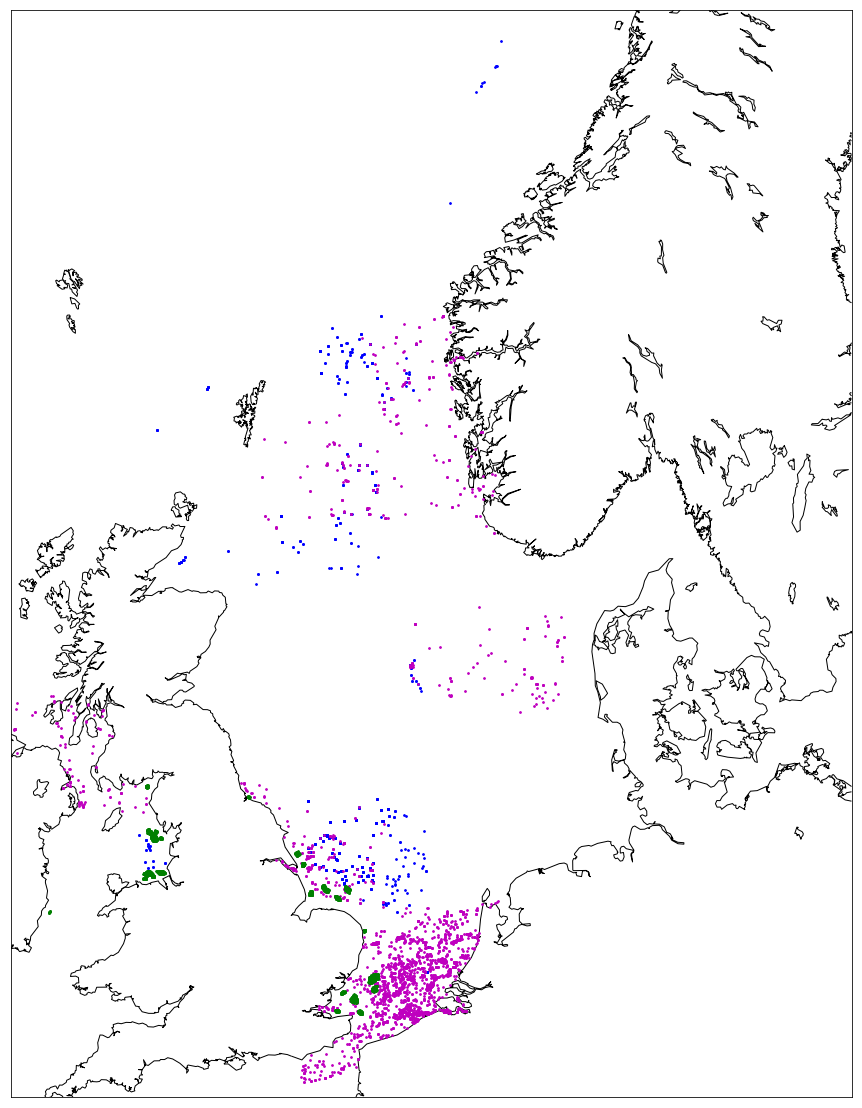

In [9]:
plt.figure(figsize=(30,20))
map = Basemap(llcrnrlon=-6.5,llcrnrlat=50,urcrnrlon=20.,urcrnrlat=65.,
             resolution='i', projection='tmerc', lat_0 = 51.5, lon_0 = -0.12)

map.drawcoastlines()
    
map.scatter(lons_oil.values, lats_oil.values, 3, zorder=5, latlon=True, c='b')
map.scatter(lons_other.values, lats_other.values, 3, zorder=5, latlon=True, c='m')
map.scatter(lons_turbine.values, lats_turbine.values, 3, zorder=5, latlon=True, c='g')
plt.show()

In [17]:
# Create a train and validation split
from sklearn.model_selection import train_test_split

x_train, x_valid, x_inc_train, x_inc_valid, x_depth_train, x_depth_valid, x_dist_train, x_dist_valid, Y_train, Y_valid = train_test_split(Xtrain,
                                    Xinc, Xdepth, Xdist, Ytrain, random_state=666, train_size=0.8, test_size=0.2)

print(x_train.shape, x_valid.shape)
print(x_inc_train.shape, x_inc_valid.shape)
print(x_depth_train.shape, x_depth_valid.shape)
print(x_dist_train.shape, x_dist_valid.shape)
print(Y_train.shape, Y_valid.shape)

(4412, 100, 100, 3) (1103, 100, 100, 3)
(4412,) (1103,)
(4412,) (1103,)
(4412,) (1103,)
(4412,) (1103,)


In [20]:
p = 0
input_shape = (100 , 100, 3)
num_classes = 3

classifier_input = Input(shape=input_shape)
inc_angle_input = Input(shape=(1,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)  
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   
x = Conv2D(num_classes,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
m = Add()([inc_angle_input, x])
out = Activation('softmax')(m)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_with_inc_angle = Model(inputs=[classifier_input, inc_angle_input], outputs=out)
model_with_inc_angle.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model_with_inc_angle.fit([x_train, x_inc_train], to_categorical(Y_train),
          batch_size=256,
          epochs=5,
          validation_data=([x_valid, x_inc_valid], to_categorical(Y_valid)))

Train on 4412 samples, validate on 1103 samples
Epoch 1/5
4412/4412 [==============================] - 7s 2ms/step - loss: 0.3859 - acc: 0.8349 - val_loss: 0.6441 - val_acc: 0.6812
Epoch 2/5
4412/4412 [==============================] - 7s 2ms/step - loss: 0.3738 - acc: 0.8410 - val_loss: 0.6479 - val_acc: 0.6839
Epoch 3/5
4412/4412 [==============================] - 7s 2ms/step - loss: 0.3613 - acc: 0.8478 - val_loss: 0.6574 - val_acc: 0.6782
Epoch 4/5
4412/4412 [==============================] - 7s 2ms/step - loss: 0.3482 - acc: 0.8595 - val_loss: 0.6764 - val_acc: 0.6537
Epoch 5/5
4412/4412 [==============================] - 7s 2ms/step - loss: 0.3438 - acc: 0.8530 - val_loss: 0.6956 - val_acc: 0.6147


In [25]:
x_inc_train.shape, x_depth_train.shape, x_dist_train.shape

((4412,), (4412,), (4412,))

In [30]:
Xtrain = get_scaled_imgs(df_train)
Xfeatures = df_train[['incidence_angle', 'water_depth', 'distance_to_land']]
Ytrain = np.array(df_train['label'])

Xtrain.shape, Xfeatures.shape, Ytrain.shape

((5515, 100, 100, 3), (5515, 3), (5515,))

In [31]:
Xfeatures.shape

(5515, 3)

In [32]:
# Create a train and validation split
from sklearn.model_selection import train_test_split

x_train, x_valid, x_features_train, x_features_valid, Y_train, Y_valid = train_test_split(Xtrain,
                                    Xfeatures, Ytrain, random_state=666, train_size=0.8, test_size=0.2)

print(x_train.shape, x_valid.shape)
print(x_features_train.shape, x_features_valid.shape)
print(Y_train.shape, Y_valid.shape)

(4412, 100, 100, 3) (1103, 100, 100, 3)
(4412, 3) (1103, 3)
(4412,) (1103,)


In [36]:
p = 0
input_shape = (100 , 100, 3)
num_classes = 3

classifier_input = Input(shape=input_shape)
features_input = Input(shape=(3,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)  
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
# x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   
x = Conv2D(num_classes,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
m = Add()([features_input, x])
out = Activation('softmax')(m)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_with_features = Model(inputs=[classifier_input, features_input], outputs=out)
model_with_features.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
model_with_features.fit([x_train, x_features_train], to_categorical(Y_train),
          batch_size=64,
          epochs=5,
          validation_data=([x_valid, x_features_valid], to_categorical(Y_valid)))

Train on 4412 samples, validate on 1103 samples
Epoch 1/5
4412/4412 [==============================] - 7s 2ms/step - loss: 8.9743 - acc: 0.4402 - val_loss: 9.0688 - val_acc: 0.4343
Epoch 2/5
4412/4412 [==============================] - 6s 1ms/step - loss: 8.9743 - acc: 0.4402 - val_loss: 9.0688 - val_acc: 0.4343
Epoch 3/5
4412/4412 [==============================] - 6s 1ms/step - loss: 8.9743 - acc: 0.4402 - val_loss: 9.0688 - val_acc: 0.4343
Epoch 4/5
4412/4412 [==============================] - 6s 1ms/step - loss: 8.9743 - acc: 0.4402 - val_loss: 9.0688 - val_acc: 0.4343
Epoch 5/5
4412/4412 [==============================] - 6s 1ms/step - loss: 8.9743 - acc: 0.4402 - val_loss: 9.0688 - val_acc: 0.4343


In [38]:
#  Use scikit-learn to grid search the activation function
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier

def create_model(activation='relu'):
    # create model
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)  
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
    # x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D()(x)   
    x = Conv2D(num_classes,(3,3), padding='same')(x)
    x = Dropout(p)(x)
    x = GlobalAveragePooling2D()(x)
    m = Add()([features_input, x])
    out = Activation('softmax')(m)

    optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model_with_features = Model(inputs=[classifier_input, features_input], outputs=out)
    model_with_features.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model_with_features


# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'X' is not defined

In [39]:
## get ice model and check that with all features and fix grid search for the conv model